In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from FRED_data_pull import *
from pathlib import Path
from datetime import datetime, timedelta
import os
import dotenv
dotenv.load_dotenv()
api_key = os.environ['FRED_API_KEY']
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error

from pandas.tseries.offsets import MonthEnd

In [2]:
copper = pull_data(['PCOPPUSDM'],
                 'm', api_key)
oil = pull_data(['DCOILWTICO'],
                 'm', api_key)
gasoline = pull_data(['GASREGW'],
                 'm', api_key)
credit_spreads = pull_data(['BAMLC0A1CAAA'],
                 'm', api_key)
mfg_hours = pull_data(['AWHMAN'],
                 'm', api_key)
new_orders = pull_data(['NEWORDER'],
                 'm', api_key)
consumer_new_orders = pull_data(['ACOGNO'],
                 'm', api_key)
housing_permits = pull_data(['PERMIT'],
                 'm', api_key)
yield_curve = pull_data(['T10Y2Y'],
                 'm', api_key)
claims = pull_data(['ICSA'],
                 'm', api_key)
cc_claims = pull_data(['CCSA'],
                 'm', api_key)
real_gdp = pull_data(['GDPC1'],
                 'q', api_key)
ind_pro = pull_data(['INDPRO'],
                 'm', api_key)
housing_starts = pull_data(['HOUST'],
                 'm', api_key)
retail_sales = pull_data(['RSAFS'],
                 'm', api_key)
pce = pull_data(['PCE'],
                 'm', api_key)

C:\Users\alex.zhang\AppData\Local\anaconda3\envs\transports\lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.stlouisfed.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\alex.zhang\AppData\Local\anaconda3\envs\transports\lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.stlouisfed.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\alex.zhang\AppData\Local\anaconda3\envs\transports\lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.stlouisfed.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1

In [3]:
file_path = Path("Monthly LEIs from FactSet.xlsx")
monthly_factset_df = pd.read_excel(file_path).set_index('date')
file_path = Path("Quarterly LEIs from FactSet.xlsx")
qtr_factset_df = pd.read_excel(file_path).set_index('date')

In [4]:
data_raw = pd.DataFrame()
#data_raw['DXY'] = dollar
data_raw['gas'] = gasoline
data_raw['oil'] = oil
data_raw['copper'] = copper
#data_raw['credit_spreads'] = credit_spreads
#data_raw['yield_curve'] = yield_curve
data_raw['mfg_hours'] = mfg_hours
data_raw['new_orders'] = new_orders
data_raw['consumer_new_orders'] = consumer_new_orders
data_raw['housing_permits'] = housing_permits
data_raw['claims'] = claims
data_raw['cc_claims'] = cc_claims
data_raw['ind_pro'] = ind_pro
data_raw['housing_starts'] = housing_starts
data_raw['retail_sales'] = retail_sales 
data_raw['pce'] = pce

data_raw = data_raw[::-1]

In [5]:
data = (np.log(data_raw) - np.log(data_raw.shift(12)))[1:]

#data['housing_permits'] = np.log(data_raw['housing_permits'])
#data['housing_starts'] = np.log(data_raw['housing_starts'])

data['credit_spreads'] = credit_spreads
data['yield_curve'] = yield_curve
data['ism_mfg'] = monthly_factset_df[['ism_mfg']]
data['financial_conditions'] = monthly_factset_df[['financial_conditions']]
data['ism_services'] = monthly_factset_df[['ism_services']]
data['consumer_expectations'] = monthly_factset_df[['consumer_expectations']]
data['expectations_vs_present'] = monthly_factset_df[['expectations_vs_present']]
#data['EXPINF2YR'] = (data_raw['EXPINF2YR'].diff()*1200)[1:]

#data.iloc[-2,3] = np.nan
#data.iloc[-2,4] = np.nan
#data.iloc[-2,5] = np.nan
#data.iloc[-2,6] = np.nan
#data.iloc[-2,7] = np.nan
#data.iloc[-2,8] = np.nan
#data.iloc[-2,9] = np.nan

In [6]:
data.corr()

,gas,oil,copper,mfg_hours,new_orders,consumer_new_orders,housing_permits,claims,cc_claims,ind_pro,housing_starts,retail_sales,pce,credit_spreads,yield_curve,ism_mfg,financial_conditions,ism_services,consumer_expectations,expectations_vs_present
gas,1.000000,0.914397,0.623040,0.429902,0.614566,0.869722,0.173073,-0.477420,-0.524972,0.545261,0.172936,0.606430,0.604467,-0.250060,-0.041157,0.338818,-0.415359,0.369366,0.092017,-0.093053
oil,0.914397,1.000000,0.621475,0.450184,0.561431,0.834095,0.130000,-0.503734,-0.490424,0.527866,0.136421,0.608304,0.611185,-0.224321,-0.036897,0.391608,-0.425859,0.371029,0.127993,-0.080875
copper,0.623040,0.621475,1.000000,0.496396,0.526269,0.572335,0.154219,-0.238604,-0.243476,0.371343,0.153522,0.465223,0.355362,-0.414669,0.011014,0.517680,-0.589072,0.438861,0.188795,0.119582
mfg_hours,0.429902,0.450184,0.496396,1.000000,0.607601,0.578780,0.396809,-0.522550,-0.498724,0.667533,0.428959,0.593915,0.471315,-0.405312,0.257280,0.612236,-0.453348,0.495097,0.177711,0.209916
new_orders,0.614566,0.561431,0.526269,0.607601,1.000000,0.736936,0.330539,-0.465384,-0.540210,0.820786,0.326830,0.667884,0.596605,-0.480953,-0.174106,0.387194,-0.411349,0.559645,0.267010,-0.087092
consumer_new_orders,0.869722,0.834095,0.572335,0.578780,0.736936,1.000000,0.282485,-0.619012,-0.637846,0.734541,0.291565,0.758985,0.737443,-0.379246,-0.024134,0.412683,-0.419867,0.443165,0.100869,-0.090383
housing_permits,0.173073,0.130000,0.154219,0.396809,0.330539,0.282485,1.000000,-0.243070,-0.242603,0.445522,0.898960,0.545676,0.302118,-0.615625,0.143411,0.380226,-0.506060,0.500054,0.397238,0.066857
claims,-0.477420,-0.503734,-0.238604,-0.522550,-0.465384,-0.619012,-0.243070,1.000000,0.923391,-0.623782,-0.282764,-0.642188,-0.791961,0.278880,-0.061778,-0.320472,0.162220,-0.431530,-0.109295,0.136795
cc_claims,-0.524972,-0.490424,-0.243476,-0.498724,-0.540210,-0.637846,-0.242603,0.923391,1.000000,-0.674405,-0.269947,-0.590126,-0.759733,0.281186,-0.021612,-0.257998,0.157925,-0.427068,-0.102753,0.181542
ind_pro,0.545261,0.527866,0.371343,0.667533,0.820786,0.734541,0.445522,-0.623782,-0.674405,1.000000,0.454273,0.725619,0.727402,-0.579778,-0.149216,0.400869,-0.372283,0.578670,0.416948,-0.186444


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


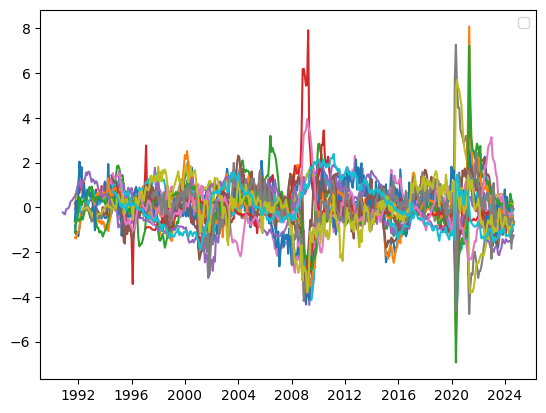

In [7]:
data_norm = (data - data.mean()) / data.std()
plt.plot(data_norm.index, data_norm)
plt.legend()
plt.show()

In [8]:
data_edited = data.copy()

#data_edited['ism_services'] = data_edited['ism_services'].shift(-1)
#data_edited['ism_mfg'] = data_edited['ism_mfg'].shift(-1)
#data_edited['mfg_hours'] = data_edited['mfg_hours'].shift(-1)
#data_edited['copper'] = data_edited['copper'].shift(1)

data_quarterly_raw = data_edited.resample('Q').mean()

In [9]:
data_quarterly_raw['ceo_confidence'] = qtr_factset_df[['ceo_confidence']]
data_quarterly_raw['eps_growth'] = qtr_factset_df[['eps_growth']]
data_quarterly_raw['sloos'] = qtr_factset_df[['sloos']]
data_quarterly_raw['real_gdp'] = (np.log(real_gdp[::-1]) - np.log(real_gdp[::-1].shift(4)))

In [10]:
data_quarterly = data_quarterly_raw.copy().dropna()

In [11]:
data_quarterly['ceo_confidence'] = data_quarterly['ceo_confidence'].shift(3)
data_quarterly['sloos'] = data_quarterly['sloos'].shift(1)
data_quarterly['consumer_expectations'] = data_quarterly['consumer_expectations'].shift(2)
data_quarterly['ism_services'] = data_quarterly['ism_services'].shift(3)
data_quarterly['ism_mfg'] = data_quarterly['ism_mfg'].shift(3)
#data_quarterly['yield_curve'] = data_quarterly['yield_curve'].shift(5)
data_quarterly['expectations_vs_present'] = data_quarterly['expectations_vs_present'].shift(5)
data_quarterly['credit_spreads'] = data_quarterly['credit_spreads'].shift(2)
data_quarterly['claims'] = data_quarterly['claims'].shift(1)
data_quarterly['cc_claims'] = data_quarterly['cc_claims'].shift(1)
data_quarterly['housing_permits'] = data_quarterly['housing_permits'].shift(2)
data_quarterly['housing_starts'] = data_quarterly['housing_starts'].shift(4)
data_quarterly['new_orders'] = data_quarterly['new_orders'].shift(1)
data_quarterly['ind_pro'] = data_quarterly['ind_pro'].shift(1)
data_quarterly['consumer_new_orders'] = data_quarterly['consumer_new_orders'].shift(1)
data_quarterly['mfg_hours'] = data_quarterly['mfg_hours'].shift(2)
data_quarterly['copper'] = data_quarterly['copper'].shift(2)
data_quarterly['oil'] = data_quarterly['oil'].shift(1)
data_quarterly['gas'] = data_quarterly['gas'].shift(1)
data_quarterly['real_gdp'] = data_quarterly['real_gdp'].shift(1)
data_quarterly['retail_sales'] = data_quarterly['retail_sales'].shift(1)
data_quarterly['financial_conditions'] = data_quarterly['financial_conditions'].shift(2)
data_quarterly['pce'] = data_quarterly['pce'].shift(1)
data_quarterly.dropna(inplace=True)

#data_quarterly = data_quarterly.drop(columns = ['oil', 'gas','housing_permits','yield_curve', 'consumer_expectations','credit_spreads','cc_claims'])

In [12]:
data_quarterly[['claims','sloos','ceo_confidence','expectations_vs_present','mfg_hours','new_orders','ism_mfg','oil','copper','financial_conditions','eps_growth']].corr()

,claims,sloos,ceo_confidence,expectations_vs_present,mfg_hours,new_orders,ism_mfg,oil,copper,financial_conditions,eps_growth
claims,1.000000,0.537500,-0.550907,-0.373212,-0.509109,-0.529463,-0.549696,-0.531137,-0.331231,0.269981,-0.613000
sloos,0.537500,1.000000,-0.688260,-0.627941,-0.623963,-0.588399,-0.659817,-0.345681,-0.456546,0.572170,-0.679201
ceo_confidence,-0.550907,-0.688260,1.000000,0.463945,0.634707,0.558528,0.816876,0.460805,0.570993,-0.608828,0.710920
expectations_vs_present,-0.373212,-0.627941,0.463945,1.000000,0.514627,0.384682,0.354968,0.157780,0.271865,-0.314684,0.495244
mfg_hours,-0.509109,-0.623963,0.634707,0.514627,1.000000,0.692965,0.677784,0.466264,0.666399,-0.585062,0.721141
new_orders,-0.529463,-0.588399,0.558528,0.384682,0.692965,1.000000,0.702858,0.700284,0.727874,-0.597834,0.760975
ism_mfg,-0.549696,-0.659817,0.816876,0.354968,0.677784,0.702858,1.000000,0.575167,0.626433,-0.603645,0.692961
oil,-0.531137,-0.345681,0.460805,0.157780,0.466264,0.700284,0.575167,1.000000,0.621284,-0.535995,0.567599
copper,-0.331231,-0.456546,0.570993,0.271865,0.666399,0.727874,0.626433,0.621284,1.000000,-0.705180,0.669304
financial_conditions,0.269981,0.572170,-0.608828,-0.314684,-0.585062,-0.597834,-0.603645,-0.535995,-0.705180,1.000000,-0.610562


## Baseline Model (OLS)

In [13]:
def recursive_estimation(X, y, model_type, origin):
    #end_of_range = len(X) - horizon

    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)

    #error_df = pd.DataFrame(columns=[f'{i+1}_step_ahead' for i in range(horizon)])

    ypred_list = []
    ytest_list = []
    for i in range(origin, len(X)):
        X_train = X[0:i]
        y_train = y[0:i]

        X_test = pd.DataFrame(X[i:i+1])
        y_test = np.array(y[i:i+1])
        
        model = model_type()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        ypred_list.append(y_pred[0])
        ytest_list.append(y_test[0])

        #scores = []
        #for k in range(len(y_pred)):
        #    score = (y_pred[k] - y_test[k])**2
        #    scores.append(score)

        #error_df.loc[len(error_df)] = scores
        
    return(np.array(ypred_list), np.array(ytest_list))#, error_df)

# Assuming you have a single feature 'X' and a target 'y'
X = data_quarterly.drop(['eps_growth'], axis = 1)
#X = data_quarterly[[['eps_growth']]]

y = data_quarterly['eps_growth']

TEST_SPLIT = 12
y_pred, y_test = recursive_estimation(X, y, LinearRegression, TEST_SPLIT)

mse = mean_squared_error(y_test, y_pred)
mae = mse**0.5
print(f"Mean Squared Error: {100*mse:.2f}")
print(f"Root Mean Squared Error: {100*mae:.2f}")
print(f"R-Squared: {np.corrcoef(y_test, y_pred)[0][1]**2}")

Mean Squared Error: 39764.64
Root Mean Squared Error: 1994.11
R-Squared: 0.3988698302805822


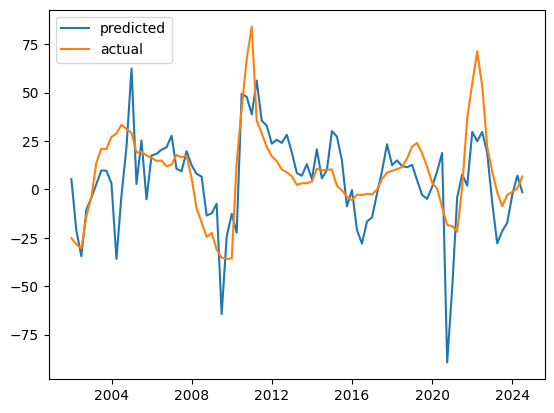

In [14]:
plt.plot(data_quarterly.index[TEST_SPLIT:], y_pred, label = 'predicted')
plt.plot(data_quarterly.index[TEST_SPLIT:], y_test, label = 'actual')
plt.legend()
plt.show()

## Nowcasting Model

In [15]:
monthly_input = data.copy()
quarterly_input = qtr_factset_df.copy()
#quarterly_input['real_gdp'] = (np.log(real_gdp[::-1]) - np.log(real_gdp[::-1].shift(4)))

monthly_input = monthly_input.drop(columns=['credit_spreads',
                                            'pce',
                                            'housing_starts',
                                            'yield_curve',
                                            'housing_permits',
                                            'cc_claims',
                                            'ism_services',
                                            'oil',
                                            'ind_pro',
                                            #'financial_conditions',
                                            'retail_sales',
                                            'consumer_new_orders',
                                            'consumer_expectations'])

for i in range(5*3):
    col_names = ['date'] + list(monthly_input.columns)
    new_row = pd.DataFrame([[np.nan]*len(col_names)], columns = col_names)
    new_row['date'] = monthly_input.index[-1] + MonthEnd(1)
    new_row = new_row.set_index('date')
    monthly_input = pd.concat([monthly_input, new_row])

for i in range(3):
    col_names = ['date'] + list(quarterly_input.columns)
    new_row = pd.DataFrame([[np.nan]*len(col_names)], columns = col_names)
    new_row['date'] = quarterly_input.index[-1] + MonthEnd(3)
    new_row = new_row.set_index('date')
    quarterly_input = pd.concat([quarterly_input, new_row])

In [16]:
quarterly_input['ceo_confidence'] = quarterly_input['ceo_confidence'].shift(3)
quarterly_input['sloos'] = quarterly_input['sloos'].shift(1)
#quarterly_input['real_gdp'] = quarterly_input['real_gdp'].shift(1)
#monthly_input['consumer_expectations'] = monthly_input['consumer_expectations'].shift(2*3)
#monthly_input['ism_services'] = monthly_input['ism_services'].shift(3*3)
monthly_input['ism_mfg'] = monthly_input['ism_mfg'].shift(3*3)
#monthly_input['yield_curve'] = monthly_input['yield_curve'].shift(5*3)
#monthly_input['credit_spreads'] = monthly_input['credit_spreads'].shift(2*3)
monthly_input['claims'] = monthly_input['claims'].shift(1*3)
monthly_input['expectations_vs_present'] = monthly_input['expectations_vs_present'].shift(5*3)
#monthly_input['cc_claims'] = monthly_input['cc_claims'].shift(1*3)
#monthly_input['housing_permits'] = monthly_input['housing_permits'].shift(2*3)
monthly_input['new_orders'] = monthly_input['new_orders'].shift(1*3)
monthly_input['financial_conditions'] = monthly_input['financial_conditions'].shift(2*3)
#monthly_input['retail_sales'] = monthly_input['retail_sales'].shift(1*3)
#monthly_input['ind_pro'] = monthly_input['ind_pro'].shift(1*3)
#monthly_input['consumer_new_orders'] = monthly_input['consumer_new_orders'].shift(1*3)
monthly_input['mfg_hours'] = monthly_input['mfg_hours'].shift(2*3)
monthly_input['copper'] = monthly_input['copper'].shift(2*3)
#monthly_input['oil'] = monthly_input['oil'].shift(1*3)
monthly_input['gas'] = monthly_input['gas'].shift(1*3)

#monthly_input = monthly_input[monthly_input.index >= '1997-07-31']
#monthly_input = monthly_input[monthly_input.index >= '1998-10-31']
#quarterly_input = quarterly_input[quarterly_input.index >= '1995-12-31']
monthly_input = monthly_input[monthly_input.index >= '1998-10-31']
quarterly_input = quarterly_input[quarterly_input.index >= '1998-12-31']

monthly_input = monthly_input.dropna(how='all')
quarterly_input = quarterly_input.dropna(how='all')

In [17]:
factors = {'eps_growth': ['Global'],
           #'real_gdp': ['Global'],
           'copper': ['Global', 'Commodities'],
           #'oil': ['Global', 'Commodities'],
           'gas': ['Global', 'Commodities'],
           'mfg_hours': ['Global', 'Output'],
           'new_orders': ['Global', 'Output'],
           #'ind_pro': ['Global', 'Output'],
           #'consumer_new_orders': ['Global', 'Manufacturing'],
           'ism_mfg': ['Global', 'Output'],
           #'retail_sales': ['Global', 'Output'],
           'expectations_vs_present': ['Global', 'Sentiment'],
           #'mfg_hours': ['Global', 'Activity'],
           #'new_orders': ['Global', 'Activity'],
           #'ism_mfg': ['Global', 'ISM'],
           #'consumer_expectations': ['Global', 'Non-Manufacturing'],
           #'ism_services': ['Global','Non-Manufacturing'],
           #'ism_services': ['Global','ISM'],
           #'housing_permits': ['Global','Housing'],
           'ceo_confidence': ['Global', 'Sentiment'],
           'sloos': ['Global', 'Financial Conditions'],
           'financial_conditions': ['Global', 'Financial Conditions'],
           #'financial_conditions': ['Global', 'Sentiment and Financial Conditions'],
           'claims': ['Global'],
           #'cc_claims': ['Global', 'Labor'],
           #'yield_curve': ['Global', 'Sentiment'],
           #'credit_spreads': ['Global', 'Sentiment'],
          }
factor_orders = {'Global': 3}
factor_multiplicities = {'Global': 1}

In [18]:
monthly_input.index.freq='M'
quarterly_input.index.freq='Q'

#if quarterly_input[-1:].isna().any() is True:
#    cutoff = 2
#else:
#    cutoff = 1

#cutoff_date = quarterly_input.index[-cutoff]

cutoff = 1
cutoff_date = quarterly_input.dropna().index[-cutoff]


In [19]:
#cutoff = 1
#const_pre = np.ones(len(data)-cutoff)
model = sm.tsa.DynamicFactorMQ(monthly_input[monthly_input.index <= cutoff_date], endog_quarterly=quarterly_input[quarterly_input.index <= cutoff_date], factors=factors, factor_orders=3, factor_multiplicities=factor_multiplicities, freq = 'M')#, enforce_stationarity=False)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of monthly variables:                      8
                   + 5 factors in 5 blocks   # of quarterly variables:                    3
                   + Mixed frequency (M/Q)   # of factor blocks:                          5
                     + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                            1998-10   Standardize variables:                    True
                                 - 2024-06                                                 
                           Observed variables / factor loadings                           
==========================================================================================
          Dep. variable     Global     Output Commodities Financial Conditions   Sentiment
------------------------------------------------------------------------------------------
                    gas       X                    X                                      
                 copper       X                    X                                      
              mfg_hours       X          X                                                
             new_orders       X          X                                                
                 claims       X                                                           
                ism_mfg       X          X                                                
   financial_conditions       X                                    X                      
expectations_vs_present       X                                                      X    
         ceo_confidence       X                                                      X    
             eps_growth       X                                                           
                  sloos       X                                    X                      
         Factor blocks:        
===============================
               block      order
-------------------------------
              Global          3
              Output          3
         Commodities          3
Financial Conditions          3
           Sentiment          3
===============================
"""

In [20]:
results = model.fit(maxiter=1000000, disp=100)

print(results.summary())

EM start iterations, llf=-2681.3
EM iteration 100, llf=-1096.1, convergence criterion=2.4816e-05
EM iteration 200, llf=-1093.7, convergence criterion=2.2399e-05
EM iteration 300, llf=-1092.5, convergence criterion=2.2279e-06
EM converged at iteration 341, llf=-1092.4, convergence criterion=9.9171e-07 < tolerance=1e-06
                               Dynamic Factor Results                              
Dep. Variable:          "gas", and 10 more   No. Observations:                  309
Model:                Dynamic Factor Model   Log Likelihood               -1092.397
                   + 5 factors in 5 blocks   AIC                           2308.793
                   + Mixed frequency (M/Q)   BIC                           2540.260
                     + AR(1) idiosyncratic   HQIC                          2401.334
Date:                     Mon, 26 Aug 2024   EM Iterations                      341
Time:                             17:38:42                                         
Sample: 

In [21]:
results.save('eps_model.pkl')

In [22]:
#if cutoff > 2:
#    results_appended = results.append(endog = monthly_input[monthly_input.index > cutoff_date], 
#                                      endog_quarterly = quarterly_input[quarterly_input.index > cutoff_date])
#else:
results_appended = results

# Specify the number of steps ahead you want to forecast
steps_ahead = 12  # For example, forecasting 12 months ahead
const_forecast = np.ones(steps_ahead)
# Generate forecasts
forecasts = results_appended.forecast(steps=steps_ahead)

forecast_dates = [cutoff_date + MonthEnd(i) for i in range(1, steps_ahead + 1)]

forecasts.index = forecast_dates

# The 'forecasts' variable now contains the forecasted values for each variable for the next 12 months
print(forecasts)


                 gas    copper  mfg_hours  new_orders    claims    ism_mfg  \
2024-07-31  0.013481  0.020537  -0.002137    0.012330 -0.065434  50.810947   
2024-08-31  0.026503  0.037474  -0.001928    0.018101 -0.071523  52.279568   
2024-09-30  0.038831  0.053451  -0.001166    0.020042 -0.077901  53.475476   
2024-10-31  0.049556  0.067324  -0.000633    0.023407 -0.083619  54.287345   
2024-11-30  0.058219  0.078500  -0.000232    0.026734 -0.087985  54.847667   
2024-12-31  0.064684  0.086785   0.000264    0.027761 -0.090544  55.299666   
2025-01-31  0.069009  0.092237   0.000495    0.029234 -0.091051  55.563819   
2025-02-28  0.071361  0.095057   0.000630    0.029743 -0.089447  55.726789   
2025-03-31  0.071962  0.095531   0.000715    0.029001 -0.085826  55.823928   
2025-04-30  0.071067  0.093991   0.000619    0.028253 -0.080404  55.824358   
2025-05-31  0.068945  0.090798   0.000470    0.026682 -0.073485  55.781938   
2025-06-30  0.065873  0.086326   0.000266    0.024593 -0.065433 

## Update Forecast

In [23]:
#start_date = str(data.index[-1])[:7]
#end_date = str(data.index[-1] + timedelta(32))[:7]
def get_news(data, data_quarterly, results, lookback=1, steps_ahead = 1):
    start_date = data_quarterly.dropna().index[-lookback]
    print(start_date)
    end_date = start_date + MonthEnd(steps_ahead*3)
    #end_date = start_date + relativedelta(months=lookback*3+1)
    #end_date = datetime(end_date.year, end_date.month, 1) - timedelta(days=1)
    print(end_date)
    #print(results.summary())

    #const_post_plus1 = np.ones(len(data) + 1)
    news = results.news(data, endog_quarterly = data_quarterly, start=start_date, end=end_date)
    return news

news = get_news(monthly_input, quarterly_input, results_appended)

print(news.summary())

2024-06-30 00:00:00
2024-09-30 00:00:00
                                      News                                     
Model:                DynamicFactorMQ   Original sample:                1998-10
Date:                Mon, 26 Aug 2024                                 - 2024-06
Time:                        17:38:43   Update through:                 2025-10
                                        # of revisions:                       0
                                        # of new datapoints:                 65
                                     Impacts                                     
impact date       impacted variable estimate (prev) impact of news estimate (new)
---------------------------------------------------------------------------------
    2024-07          ceo_confidence           49.70          -1.76          47.75
        NaT                  claims           -0.07           0.04          -0.03
        NaT                  copper            0.02          -0.10    

In [24]:
def update_forecast_data(forecast_df, news):#,length=2):
    #if length < 2:
    #    length = 2
    
    new_df = forecast_df.copy()
    #num_cols = len(new_df.columns)
    for i in range(len(news.impacts)):
        revision_date = news.impacts.index[i][0]
        revision_date = pd.to_datetime(str(revision_date) + "-01") + MonthEnd(1)
        #print(revision_date)
        col_name = news.impacts.index[i][1]
        new_df.loc[revision_date, col_name] = news.impacts.iloc[i,4]
    return new_df


def combine_data(history_df, forecast_df):
    #print(data)
    num_cols = len(history_df.columns)
    if num_cols == len(forecast_df.columns):
        new_df = pd.concat([history_df, forecast_df])
        #new_df = new_df[~new_df.index.duplicated(keep='first')]
        for i in range(num_cols):
            for j in range(1, len(forecast_df)+1):
                if np.isnan(new_df.iloc[-j,i]):
                    new_df.iloc[-j,i] = forecast_df.iloc[-j,i]
        return new_df
    else:
        raise ValueError()

new_forecasts = update_forecast_data(forecasts, news)
#new_forecasts.index = new_forecasts.index.to_timestamp('M')
new_forecasts_quarterly = new_forecasts[quarterly_input.columns].resample('Q').last()
new_data = combine_data(quarterly_input, new_forecasts_quarterly)
new_data.tail(10)

,ceo_confidence,eps_growth,sloos
2023-12-31,43.000000,-1.309150,50.800000
2024-03-31,42.000000,0.536779,33.900000
2024-06-30,48.000000,6.671620,14.500000
2024-09-30,46.000000,NaN,15.600000
2024-12-31,53.000000,NaN,NaN
2025-03-31,54.000000,NaN,NaN
2024-09-30,46.000000,7.412231,15.600000
2024-12-31,52.021526,11.275192,4.481910
2025-03-31,52.807917,12.086272,3.660724
2025-06-30,52.956894,11.728459,4.103330


In [25]:
quarterly_input['eps_growth'].dropna().tail(10)

date
2022-03-31    71.315000
2022-06-30    53.360500
2022-09-30    21.878300
2022-12-31     9.072370
2023-03-31    -1.525060
2023-06-30    -8.636280
2023-09-30    -2.863210
2023-12-31    -1.309150
2024-03-31     0.536779
2024-06-30     6.671620
Freq: Q-DEC, Name: eps_growth, dtype: float64

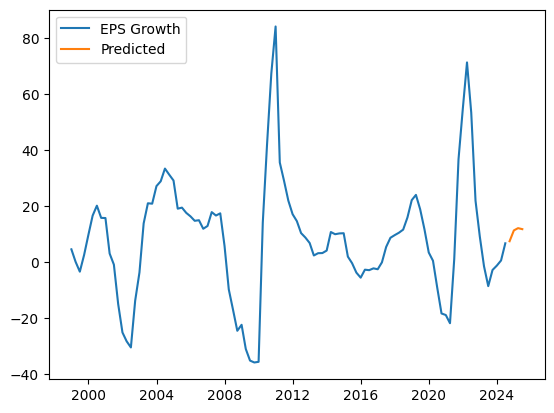

In [26]:
plt.plot(quarterly_input.dropna().index, quarterly_input.dropna()['eps_growth'], label='EPS Growth')
plt.plot(new_forecasts_quarterly.index, new_forecasts_quarterly['eps_growth'], label='Predicted')#, linestyle='--')
plt.legend()
plt.show()

## Recursive Estimation

In [172]:
def recursive_estimation(data_monthly, data_quarterly, y_names: list, factors = 1, factor_orders = 3, factor_multiplicities = 1, steps_ahead = 1, start_point = 50, missing_vars_q = None, missing_vars_m = None):

    for y_name in y_names:
        if (y_name not in data_monthly.columns) and (y_name not in data_quarterly.columns):
            raise ValueError()
    
    # Find missing vars based on distance from last quarter of full data if no missing vars are inputted 
   # cutoff_date = data_quarterly.dropna().index[-1]
    #next_quarter = cutoff_date+MonthEnd(steps_ahead*3)

    num_blanks_q = len(data_quarterly) - len(data_quarterly.dropna())
    if missing_vars_q is None:
        #missing_vars_q = quarterly_input[quarterly_input.index <= next_quarter].iloc[-num_blanks:].isna().reset_index(drop = True)
        missing_vars_q = quarterly_input.iloc[-num_blanks_q:].isna().reset_index(drop = True)

    num_blanks_m = len(data_monthly) - len(data_monthly.dropna())
    if missing_vars_m is None:
        #missing_vars_m = monthly_input[monthly_input.index <= next_quarter].iloc[-num_blanks*3:].isna().reset_index(drop = True)
        missing_vars_m = monthly_input.iloc[-num_blanks_m:].isna().reset_index(drop = True)

    #if data.index[2] != data_quarterly.index[0]:
        

    #all_columns = list(data_monthly.columns) + list(data_quarterly.columns)
    errors_df = pd.DataFrame(0, index=range(steps_ahead), columns=data_quarterly.columns)
    preds_dfs = [pd.DataFrame(columns=data_quarterly.columns)]*steps_ahead

    if steps_ahead > num_blanks_q:
        T = steps_ahead
    else:
        T = num_blanks_q
    
    for i in range(start_point, len(data_quarterly.dropna())-steps_ahead+1):
    #for i in range(start_point, len(data_quarterly.dropna())-T+1):
        print(len(data_quarterly.dropna()) - i)
        #print(i)
        print(f"Training Sample Ending {str(data_quarterly[:i].index[-1])}")
        model = sm.tsa.DynamicFactorMQ(data_monthly[:i*3], endog_quarterly = data_quarterly[:i], factors=factors, factor_orders=factor_orders, factor_multiplicities = factor_multiplicities)#,enforce_stationarity=False)
        results = model.fit(maxiter=100000, disp=100)

        # Generate forecasts and adjust datetime index to be compatible with rest of data
        forecasts = results.forecast(steps=steps_ahead*3)
        forecast_dates = [data_quarterly.index[i-1] + MonthEnd(k) for k in range(1, steps_ahead*3 + 1)]
        forecasts.index = forecast_dates
        #print(forecasts)

        if missing_vars_q.any().any() or missing_vars_m.any().any():

            # Extend monthly data to include "news"
            #new_cutoff_m = (i+steps_ahead)*3
            new_cutoff_m = i*3+num_blanks_m
            new_data_monthly = data_monthly.copy()[:new_cutoff_m]

            # Extend quarterly data to include "news"
            #new_cutoff_q = i_steps_ahead
            new_cutoff_q = i+num_blanks_q
            new_data_quarterly = data_quarterly.copy()[:new_cutoff_q]

            # Replace values in new monthly data with NAs based on inputted missing variables
            for j, _ in enumerate(new_data_monthly.columns):
                for k in range(num_blanks_m):
                    if missing_vars_m.iloc[k, j] == True:
                        new_data_monthly.iloc[i*3+k, j] = np.nan

           # Replace values in new quarterly data with NAs based on inputted missing variables
            for j, _ in enumerate(new_data_quarterly.columns):
                for k in range(num_blanks_q):
                    if missing_vars_q.iloc[k, j] == True:
                        new_data_quarterly.iloc[i+k, j] = np.nan

            news = get_news(new_data_monthly, new_data_quarterly, results, steps_ahead = steps_ahead)
            #print(new_data_quarterly)
            #print(new_data_monthly)
            #print(news.summary())
            forecasts = update_forecast_data(forecasts, news)
            #print(forecasts)
            #forecasts.index = forecasts.index.to_timestamp('M')
            forecasts = forecasts[data_quarterly.columns].resample('Q').last()
            forecasts = forecasts[:steps_ahead]
            #print(forecasts)
            
        # Compare Observed Values with Forecast and Record Results
        observed = data_quarterly.copy()[i:i+steps_ahead]
        has_nans = observed.isna().any().any()
        if not has_nans:
            error = (forecasts - observed).reset_index(drop = True)
            errors_df = errors_df + error**2
        #display(errors_df)
        
        for k in range(steps_ahead):
            preds_dfs[k] = pd.concat([preds_dfs[k], forecasts[k:k+1]])

    errors_df = (errors_df / (len(data_quarterly.dropna()) - start_point - steps_ahead + 1))**0.5
    
    errors_df = errors_df[y_names]
        
    return preds_dfs, errors_df

In [173]:
steps_ahead = 4

#next_quarter = cutoff_date+MonthEnd(steps_ahead*3)

start_index=50
start_point = len(quarterly_input.dropna()) - start_index

num_blanks_q = len(quarterly_input) - len(quarterly_input.dropna())
#missing_vars_q = quarterly_input[quarterly_input.index <= next_quarter].iloc[-num_blanks:].isna().reset_index(drop = True)
missing_vars_q = quarterly_input.iloc[-num_blanks_q:].isna().reset_index(drop = True)

num_blanks_m = len(monthly_input) - len(monthly_input.dropna())
#missing_vars_m = monthly_input[monthly_input.index <= next_quarter].iloc[-num_blanks*3:].isna().reset_index(drop = True)
missing_vars_m = monthly_input.iloc[-num_blanks_m:].isna().reset_index(drop = True)

y_names = ['eps_growth']
preds_dfs, errors_df = recursive_estimation(monthly_input,
                                            quarterly_input,
                                            y_names,
                                            factors = factors,
                                            factor_orders = 3,
                                            factor_multiplicities = factor_multiplicities,
                                            steps_ahead = steps_ahead,
                                            start_point = start_point,
                                            missing_vars_q = missing_vars_q,
                                            missing_vars_m = missing_vars_m)

50
Training Sample Ending 2011-09-30 00:00:00
EM start iterations, llf=-574.41
EM iteration 100, llf=-350.5, convergence criterion=0.00013074
EM iteration 200, llf=-348.55, convergence criterion=1.6598e-05
EM iteration 300, llf=-348.07, convergence criterion=1.4716e-05
EM iteration 400, llf=-347.18, convergence criterion=3.4632e-05
EM iteration 500, llf=-346.36, convergence criterion=1.3151e-05
EM iteration 600, llf=-346.04, convergence criterion=7.0142e-06
EM iteration 700, llf=-345.84, convergence criterion=4.7705e-06
EM iteration 800, llf=-345.7, convergence criterion=3.5397e-06
EM iteration 900, llf=-345.59, convergence criterion=2.8452e-06
EM iteration 1000, llf=-345.5, convergence criterion=2.4939e-06
EM iteration 1100, llf=-345.42, convergence criterion=2.402e-06
EM iteration 1200, llf=-345.33, convergence criterion=2.5653e-06
EM iteration 1300, llf=-345.23, convergence criterion=3.1859e-06
EM iteration 1400, llf=-345.09, convergence criterion=6.3275e-06
EM iteration 1500, llf=-

In [174]:
errors_df

,eps_growth
0,5.378954
1,8.827212
2,10.210107
3,12.568422


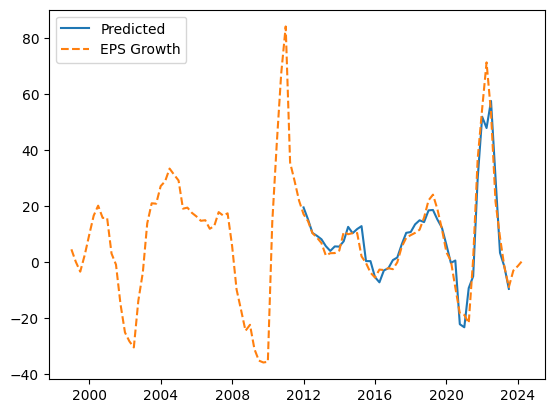

In [175]:
plt.plot(preds_dfs[0].index, preds_dfs[0]['eps_growth'], label='Predicted')
plt.plot(quarterly_input.index, quarterly_input['eps_growth'], label='EPS Growth', linestyle='--')
plt.legend()
plt.show()

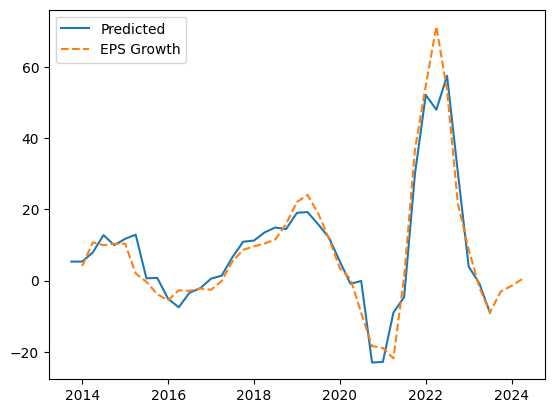

In [163]:
plt.plot(preds_dfs[0].index[-40:], preds_dfs[0]['eps_growth'][-40:], label='Predicted')
plt.plot(quarterly_input.index[-45:], quarterly_input['eps_growth'][-45:], label='EPS Growth', linestyle='--')
plt.legend()
plt.show()

In [141]:
preds_dfs[0]['real_gdp'].tail(10)

KeyError: 'real_gdp'

In [ ]:
quarterly_input['real_gdp'].dropna().tail(10)

In [ ]:
def get_r_squared(var_name, pred_df, actual_df):
    r2 = np.round(np.corrcoef(pred_df[var_name], actual_df[var_name])[1][0]**2*100, 1)
    return r2
         
#mse = errors_df[var_name][0]
r2 = get_r_squared('eps_growth', preds_dfs[0], quarterly_input.dropna()[start_point:-steps_ahead+1])

#print(f"Root Mean Squared Error: {mse}")
print(f"R-Squared : {r2}")